# Load Data and pretrained networks

In [10]:
import os
import sys
import keras
import matplotlib as mpl
import code.visualization # own functions to visualize heatmaps hardcoded
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import numpy as np
from keras import activations
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input
from keras.utils import to_categorical
import imageio
from code import visualization

In [3]:
vgg16 = VGG16(weights='imagenet')

In [4]:
img = imageio.imread('imgs/bittern.jpg') #object and background are clearly distinguishable - background contains noise
x = preprocess_input(img[np.newaxis, :])
y = np.asarray(133)[np.newaxis] #true category is 133

In [5]:
y_pred = vgg16.predict(x) # confirm that net predicts correctly for this image
print(np.argmax(y_pred) ==y)

[ True]


## Saliency

In [6]:
from vis.visualization import visualize_saliency, overlay,visualize_cam,get_num_filters, visualize_activation
from vis.utils import utils as kerasvis_utils

In [7]:
# last layer needs to be linear instead of softmax so that 
vgg16.layers[-1].activation = activations.linear
vgg16 = kerasvis_utils.apply_modifications(vgg16)

/home/lauri/.conda/envs/my_old_tensor/lib/python3.5/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
idx = 0 #use the first (and only) image

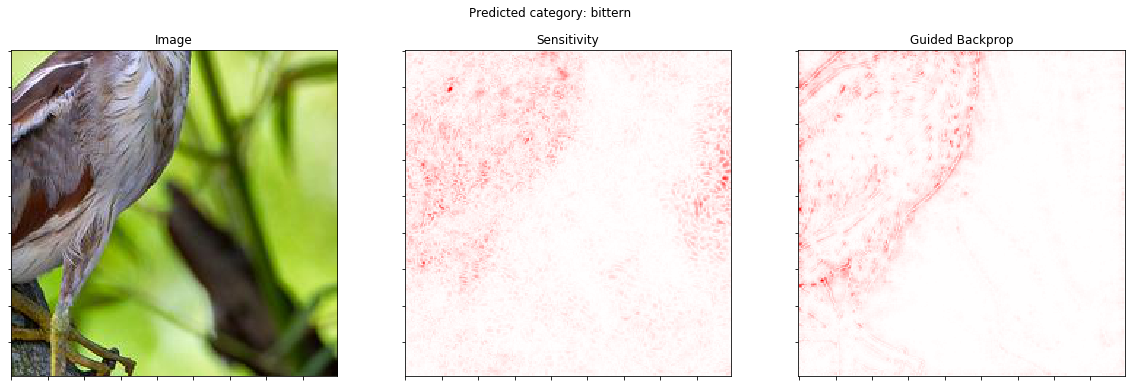

In [11]:
sens_grads = visualize_saliency(vgg16, -1, filter_indices=y[idx], seed_input=x[idx])

gp_grads = visualize_saliency(vgg16, -1, filter_indices=y[idx], seed_input=x[idx], backprop_modifier = 'guided')

visualization.plot_sensitivity(img, sens_grads, gp_grads ,decode_predictions(y_pred[idx:idx+1])[0][0][1], "Test")

# GradCAM


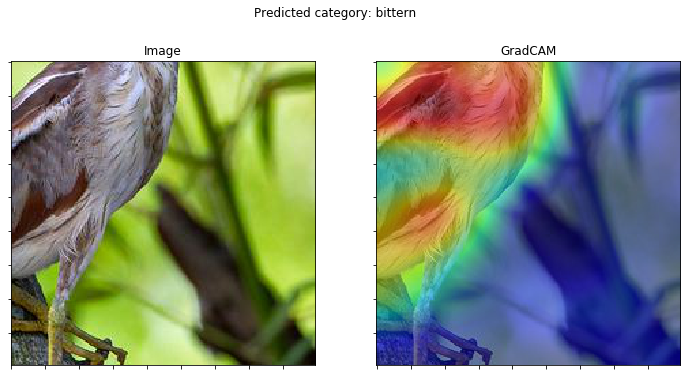

In [12]:
# normally we would have to do linear activations for this layer as well

gp_cam_grads = visualize_cam(vgg16, -1, filter_indices=np.argmax(y_pred[idx]), seed_input=x[idx], backprop_modifier = 'guided')

gp_cam_grads_ov =overlay( np.uint8(mpl.cm.jet(gp_cam_grads)[..., :3] * 255), img)

visualization.plot_cam(img,gp_cam_grads_ov ,decode_predictions(y_pred[idx:idx+1])[0][0][1],"Test")

## LIME

In [13]:
import lime
from lime import lime_image

In [14]:
# LIME does 'need' the softmax - it is easier to train a linear classifier 
# we could replace the activations again or simply reload the network
vgg16 = VGG16(weights='imagenet')

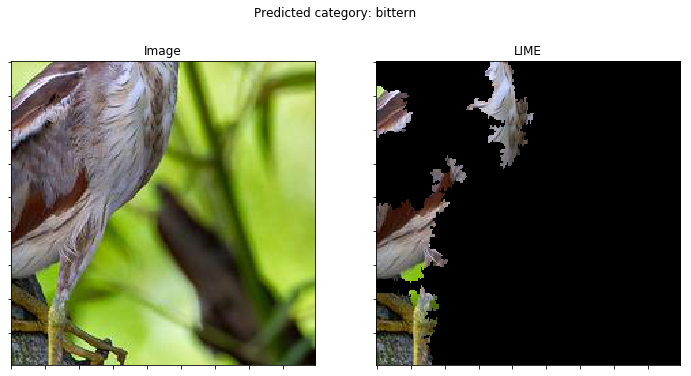

In [15]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(x[idx].astype(np.int32), vgg16.predict, top_labels=10, hide_color=0)
temp, mask = explanation.get_image_and_mask(y_pred[idx].argmax(), positive_only=True, num_features=8, hide_rest=True)#, num_samples=1000)
visualization.plot_lime(img,mask[:,:,np.newaxis]*img,decode_predictions(y_pred[idx:idx+1])[0][0][1],"Test")

## Visualize layer activation


In [16]:
# Swap softmax with linear
#otherwise there is just noise in the output since the outputs influence each other
vgg16.layers[-1].activation = activations.linear
vgg16 = kerasvis_utils.apply_modifications(vgg16)

/home/lauri/.conda/envs/my_old_tensor/lib/python3.5/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


bittern


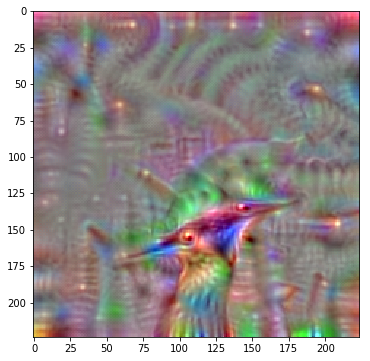

In [17]:
a = np.zeros((1,1000))
a[0,133]=1
img = visualize_activation(vgg16, 22, filter_indices=np.argmax(a))
fig = plt.figure(figsize=(6, 6))
plt.imshow(img)
print(decode_predictions(a)[0][0][1]) # print category this corresponds to